## Langgraph - 节点与可控制性
*****
- 第一个Langgraph
- 基本控制：串行控制
- 基本控制：分支控制
- 基本控制：条件分支与循环
- 基本控制：图的可视化
- 精细控制：图的运行时配置
- 精细控制：map-reduce

## 第一个Langgraph
*****

In [1]:
! pip install -U langgraph

  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.3.8
    Uninstalling langgraph-0.3.8:
      Successfully uninstalled langgraph-0.3.8

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


定义state
****
- TypedDict:属于 Python 标准库 typing 模块的一部分,仅提供静态类型检查，运行时不执行验证
- Pydantic:第三方库，需要单独安装,提供运行时数据验证和序列化功能

In [11]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

# 节点间通讯的消息类型
class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

定义节点
***


In [12]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("你好!")

    return {"messages": messages + [new_message], "extra_field": 10}

创建图
****
- 包含一个节点
- 使用state通信

In [13]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

查看节点与图结构（内置）
****
Mermaid 是一种基于文本的图表和可视化工具，它允许用户通过简单的文本语法来创建复杂的图表和流程图。它特别适合开发者、文档编写者和技术人员在文档、代码库或网页中嵌入可视化内容。

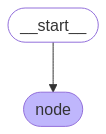

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

使用langgraph图结构
***

In [15]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='你好!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

使用 pretty_print 来格式化显示
***

In [16]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

你好!


### 串行控制
****

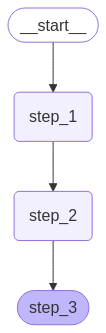

In [18]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import START, StateGraph

class State(TypedDict):
    value_1: str
    value_2: int

def step_1(state: State):
    return {"value_1": "a"}

def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}

def step_3(state: State):
    return {"value_2": 10}


graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# Add edges
graph_builder.add_edge(START, "step_1")
graph_builder.add_edge("step_1", "step_2")
graph_builder.add_edge("step_2", "step_3")

graph = graph_builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))


In [19]:
graph.invoke({"value_1": "c"})

{'value_1': 'a b', 'value_2': 10}

### 分支控制
****
![](langgraph1.png)


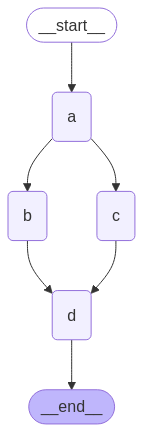

In [20]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Annotated允许为类型提示添加额外的元数据，而不影响类型检查器对类型本身的理解
class State(TypedDict):
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

### 条件分支与循环
***


In [22]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

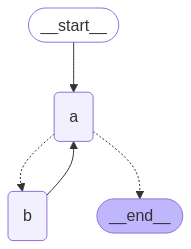

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B']
Node B sees ['A', 'B', 'A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

使用递归限制recursion_limit，防止异常情况下的大量无用调用

In [25]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Recursion Error


循环

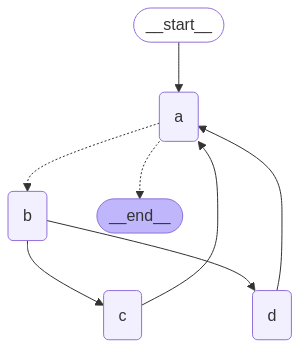

In [26]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Node C sees {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Node D sees {state["aggregate"]}')
    return {"aggregate": ["D"]}


# 节点
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)


# 边
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "c")
builder.add_edge("b", "d")
builder.add_edge(["c", "d"], "a")
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

1. 节点A
2. 节点B
3. 节点C或节点D
4. 节点A

In [27]:
result = graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node C sees ['A', 'B']
Node D sees ['A', 'B']
Node A sees ['A', 'B', 'C', 'D']
Node B sees ['A', 'B', 'C', 'D', 'A']
Node C sees ['A', 'B', 'C', 'D', 'A', 'B']
Node D sees ['A', 'B', 'C', 'D', 'A', 'B']
Node A sees ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


### 图的运行时配置
****

In [29]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_deepseek import ChatDeepSeek
from langchain_openai import ChatOpenAI
import os
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.graph import END, StateGraph, START

model = ChatDeepSeek(
    model="Pro/deepseek-ai/DeepSeek-V3",
    temperature=0,
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    base_url=os.environ.get("DEEPSEEK_API_BASE"),
)

model1 = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url=os.environ.get("OPENAI_API_BASE"),
)

# 定义要切换的模型
models = {
    "deepseek": model,
    "openai": model1,
}


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


def _call_model(state: AgentState, config: RunnableConfig):
    # 使用LCEL的配置
    model_name = config["configurable"].get("model", "deepseek")
    model = models[model_name]
    response = model.invoke(state["messages"])
    return {"messages": [response]}


# Define a new graph
builder = StateGraph(AgentState)
builder.add_node("model", _call_model)
builder.add_edge(START, "model")
builder.add_edge("model", END)

graph = builder.compile()

没有增加运行时配置的情况下，它会默认调用deepseek

In [31]:
graph.invoke({"messages": [HumanMessage(content="hi 你是谁？")]})

{'messages': [HumanMessage(content='hi 你是谁？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='你好呀！😊 我是DeepSeek Chat，由深度求索公司创造的智能AI助手。我可以帮你解答问题、提供建议、陪你聊天，或者协助你处理各种任务！有什么我可以帮你的吗？✨', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 7, 'total_tokens': 54, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Pro/deepseek-ai/DeepSeek-V3', 'system_fingerprint': '', 'finish_reason': 'stop', 'logprobs': None}, id='run-cc972b28-136e-4528-b147-768ae403b4fb-0', usage_metadata={'input_tokens': 7, 'output_tokens': 47, 'total_tokens': 54, 'input_token_details': {}, 'output_token_details': {}})]}

增加运行时配置，动态切换模型

In [32]:
config = {"configurable": {"model": "openai"}}
graph.invoke({"messages": [HumanMessage(content="hi 你是谁？")]}, config=config)

{'messages': [HumanMessage(content='hi 你是谁？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='你好，我是一个人工智能助手。我可以回答你的问题和提供帮助。有什么可以帮到你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 14, 'total_tokens': 58, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': 'fp_0165350fbb', 'finish_reason': 'stop', 'logprobs': None}, id='run-7cfaec6c-cd0d-45d3-b565-bc433f4c5765-0', usage_metadata={'input_tokens': 14, 'output_tokens': 44, 'total_tokens': 58, 'input_token_details': {}, 'output_token_details': {}})]}

### MapReduce并行执行
****
给定一个来自用户的一般主题，生成相关主题列表，为每个主题生成一个笑话，并从结果列表中选择最佳笑话。
![](langgraph2.png)

In [33]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

from langchain_deepseek import ChatDeepSeek

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field

# 模型和提示词
# 定义我们将使用的模型和提示词
subjects_prompt = """生成一个逗号分隔的列表，包含2到5个与以下主题相关的例子：{topic}。"""
joke_prompt = """生成一个关于{subject}的笑话"""
best_joke_prompt = """以下是一些关于{topic}的笑话。选出最好的一个！返回最佳笑话的ID。

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int = Field(description="最佳笑话的索引，从0开始", ge=0)


model = ChatDeepSeek(
    model="Pro/deepseek-ai/DeepSeek-V3",
    temperature=0,
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    base_url=os.environ.get("DEEPSEEK_API_BASE"),
)

# 图组件：定义构成图的组件


# 这将是主图的整体状态。
# 它将包含一个主题（我们期望用户提供）
# 然后将生成一个主题列表，并为每个主题生成一个笑话
class OverallState(TypedDict):
    topic: str
    subjects: list
    # 注意这里我们使用operator.add
    # 这是因为我们想把从各个节点生成的所有笑话
    # 合并回一个列表 - 这本质上是"归约"部分
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# 这将是我们将"映射"所有主题的节点的状态
# 用于生成笑话
class JokeState(TypedDict):
    subject: str


# 这是我们用来生成笑话主题的函数
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# 这里我们根据给定的主题生成笑话
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# 这里我们定义映射到生成的主题上的逻辑
# 我们将在图中使用这个作为边缘
def continue_to_jokes(state: OverallState):
    # 我们将返回一个`Send`对象列表
    # 每个`Send`对象包含图中节点的名称
    # 以及要发送到该节点的状态
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# 这里我们将评判最佳笑话
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# 构建图：这里我们将所有内容组合在一起构建我们的图
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()


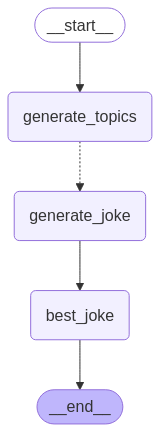

In [34]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

使用

In [35]:
for s in app.stream({"topic": "动物"}):
    print(s)

{'generate_topics': {'subjects': ['狮子', '大象', '企鹅', '海豚', '蝴蝶']}}
{'generate_joke': {'jokes': ['为什么海豚总是那么开心？因为它们每天都在‘海’皮！']}}
{'generate_joke': {'jokes': ['为什么蝴蝶总是迟到？因为它们总是在“蝶”时间！']}}
{'generate_joke': {'jokes': ['为什么企鹅从不迟到？因为它们总是穿着‘燕尾服’！']}}
{'generate_joke': {'jokes': ['为什么大象不会用电脑？因为它们总是把鼠标踩坏！']}}
{'generate_joke': {'jokes': ['为什么狮子从不玩扑克？因为老虎总是作弊！']}}
{'best_joke': {'best_selected_joke': '为什么狮子从不玩扑克？因为老虎总是作弊！'}}
